In [37]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
# from pmdarima.arima import auto_arima
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.stattools import adfuller, kpss
# import statsmodels.api as sm
# from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
# from statsmodels.tsa.arima_model import ARIMAResults
from keras.models import Sequential
from keras.layers import GRU,LSTM,Dense,BatchNormalization
import tensorflow as tf

<ipython-input-37-bea24b60a942>:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [56]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df.tail(40)

,price
day,
2021-02-23,82000.0
2021-02-24,82000.0
2021-02-25,85300.0
2021-02-26,82500.0
2021-03-02,83600.0
2021-03-03,84000.0
2021-03-04,82400.0
2021-03-05,82100.0
2021-03-08,82000.0


In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = scaler.fit_transform(samsung_df)
# df

In [40]:
num_feature = 8
window = list()
temp = 0
for i in range(len(df)-num_feature):
  for j in range(num_feature+1):
    window.append(df[temp+j])
  temp = temp + 1

In [41]:
len(window)

2826

In [42]:
X_test = window[-8:]
X_test = np.array(X_test).reshape(1,1,num_feature)
# X_test


In [43]:
window = np.array(window).reshape(df.shape[0]-num_feature,num_feature+1)
# window

In [44]:
df2 = pd.DataFrame(window)
# print(.shape)
trainx = df2.iloc[:,:-1].copy().to_numpy().reshape(len(window),1,num_feature)
trainy = df2.iloc[:,-1].copy().to_numpy().reshape(len(window),1,1)



In [69]:
from tensorflow.python.ops.math_ops import TruncateDiv
def rnn_model(trainx,trainy,X_test):
  model = Sequential()
  model.add(GRU(32, dropout = 0.1, kernel_regularizer = tf.keras.regularizers.l2(0.02),
                recurrent_dropout=0.2, return_sequences = True,
                input_shape = (1,8), activation = 'relu'))
  # model.add(BatchNormalization())
  model.add(GRU(16, dropout = 0.1, kernel_regularizer = tf.keras.regularizers.l2(0.02),
                recurrent_dropout=0.2, return_sequences = False,
                input_shape = (1,8), activation = 'relu'))
  # model.add(BatchNormalization())
  # batch normalization이 필수..?
  # model.add(BatchNormalization())
  model.add(Dense(1))

  model.compile(optimizer = 'adam', loss = 'mae')

  history = model.fit(trainx,trainy,epochs = 40, batch_size = 50,
            shuffle = False, verbose = 0, validation_split = 0.2)
  predictions = model.predict(X_test)

  return history, predictions

In [73]:
history, predictions = rnn_model(trainx,trainy,X_test)


1/1 [==============================] - 1s 615ms/step


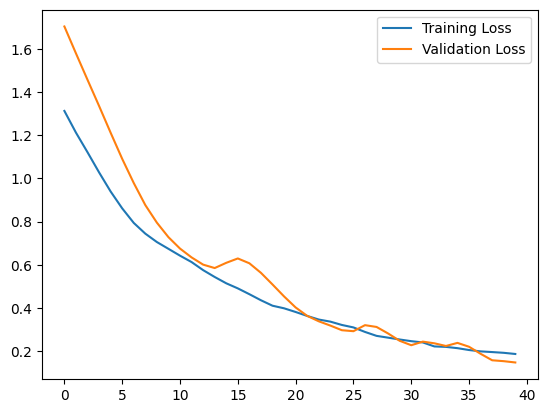

In [74]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

In [75]:
next_price = scaler.inverse_transform(predictions.reshape(-1,1))
next_price[0,0]

83074.77